In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as tsa_plots
from pandas.plotting import lag_plot

import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12, 5

In [2]:
data = pd.read_excel('Airlines+Data.xlsx')
data.head(10)

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
5,1995-06-01,135
6,1995-07-01,148
7,1995-08-01,148
8,1995-09-01,136
9,1995-10-01,119


# EDA and data visualization

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [4]:
data_airlines = pd.read_excel('Airlines+Data.xlsx', index_col = 0)
data_airlines.head(10)

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
1995-06-01,135
1995-07-01,148
1995-08-01,148
1995-09-01,136


In [5]:
data_airlines.shape

(96, 1)

Text(0, 0.5, 'passengers')

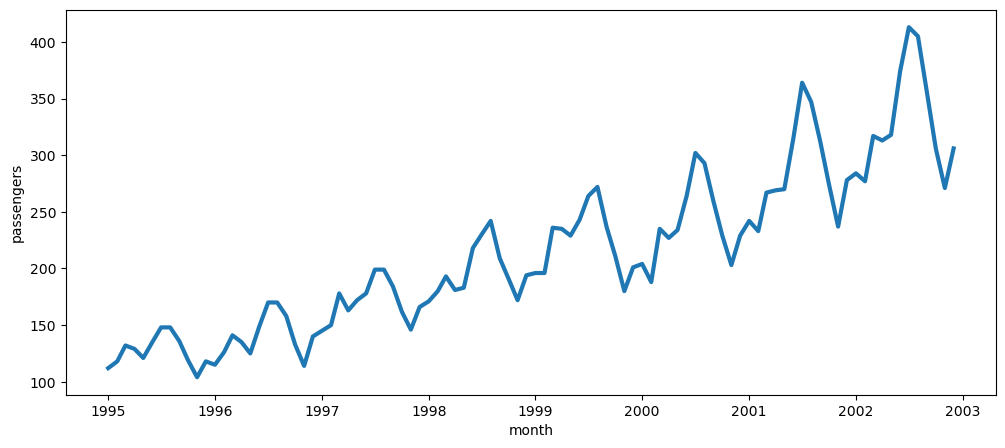

In [6]:
plt.plot(data_airlines,linewidth=3)
plt.xlabel("month")
plt.ylabel("passengers")

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

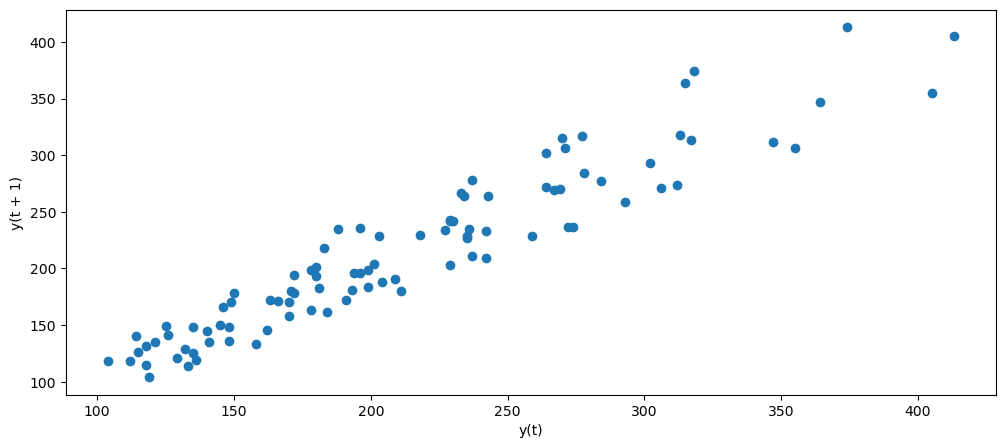

In [7]:
lag_plot(data_airlines)

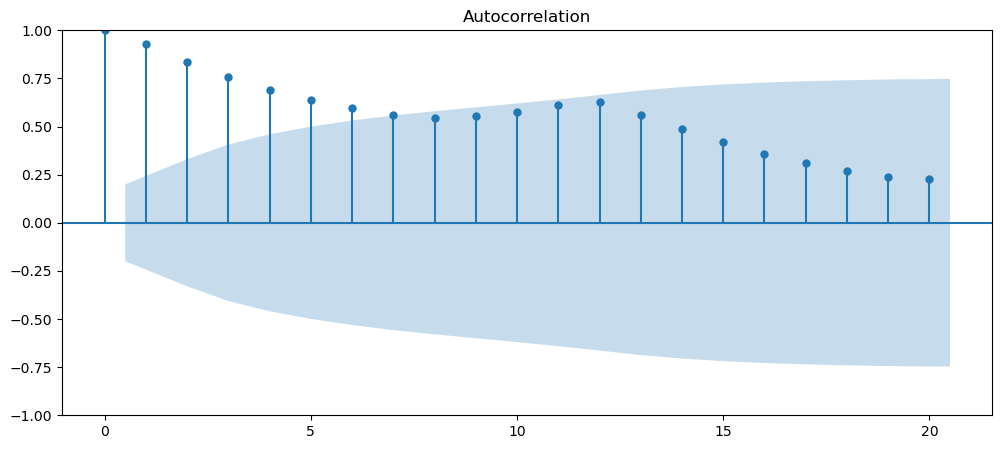

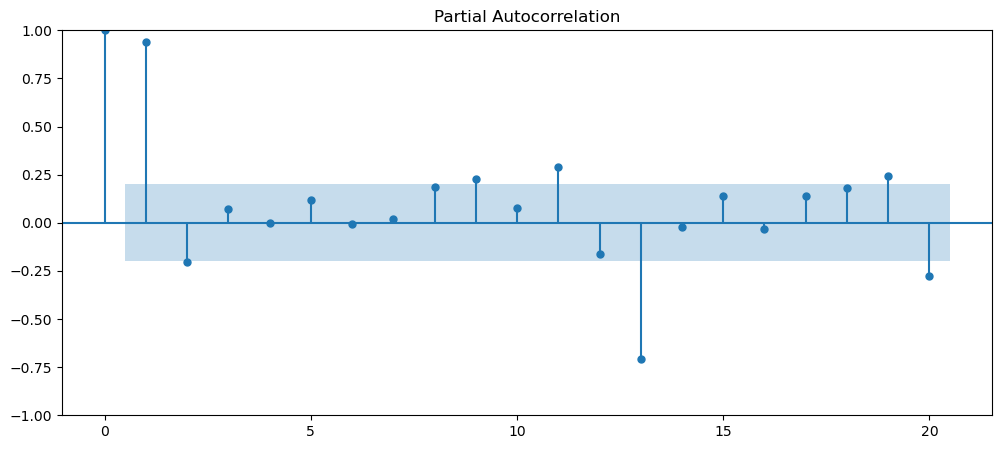

In [8]:
tsa_plots.plot_acf(data_airlines,lags=20)
tsa_plots.plot_pacf(data_airlines,lags=20);

# Train Test split

In [9]:
train = data_airlines.head(90)
test = data_airlines.tail(10)

In [10]:
test

,Passengers
Month,
2002-03-01,317
2002-04-01,313
2002-05-01,318
2002-06-01,374
2002-07-01,413
2002-08-01,405
2002-09-01,355
2002-10-01,306
2002-11-01,271


# plotting moving average

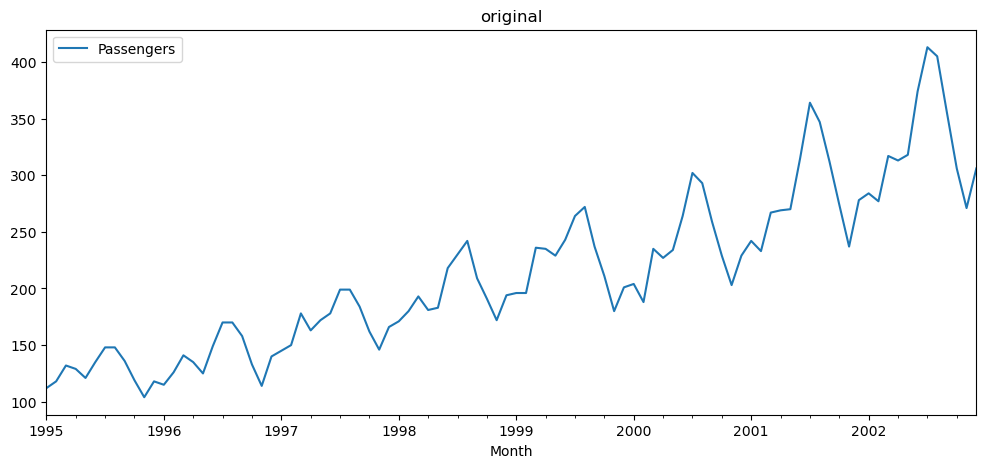

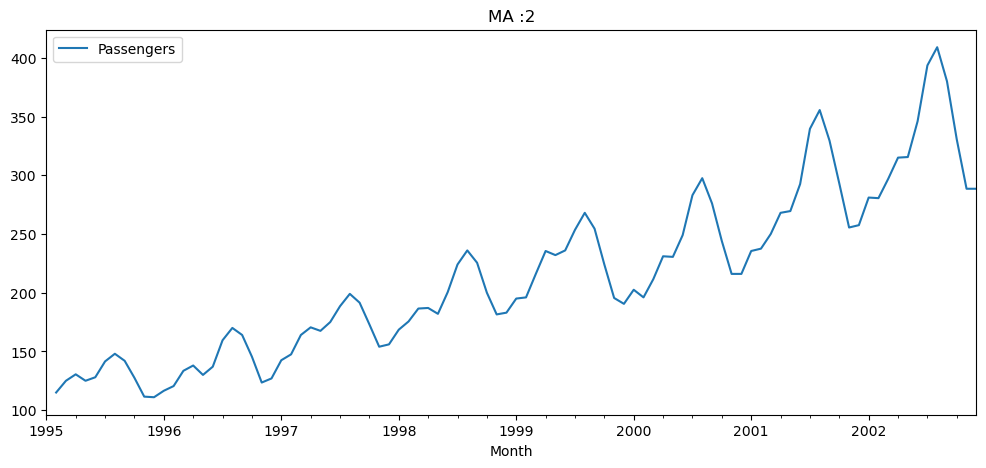

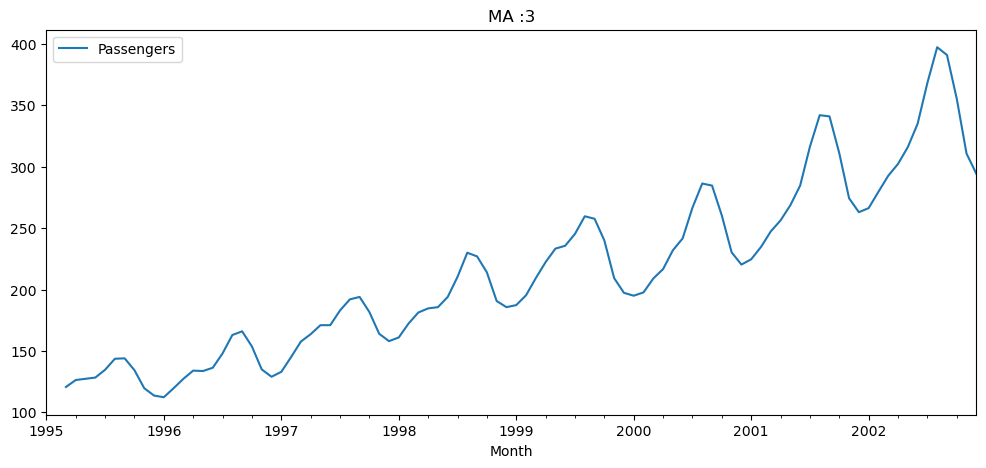

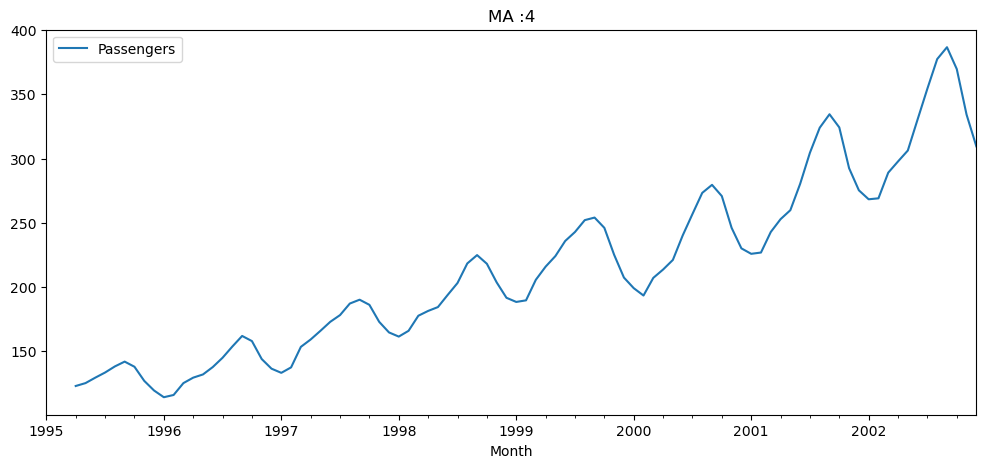

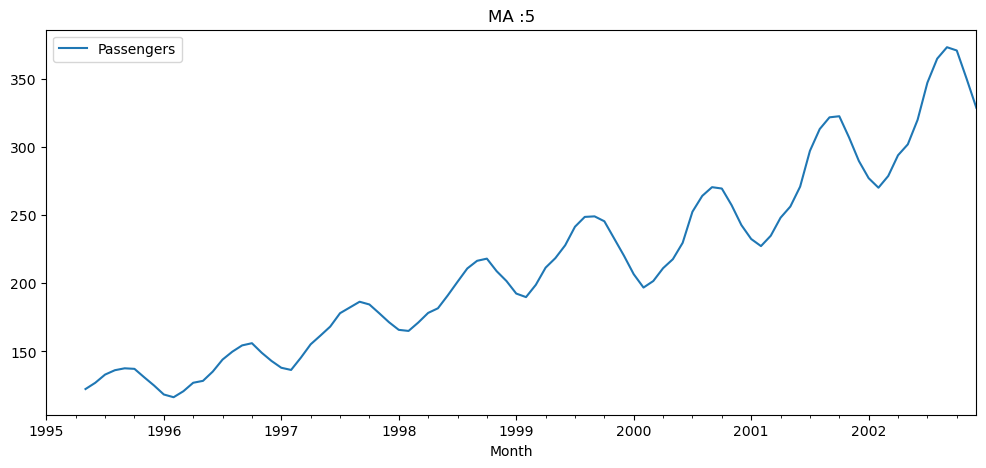

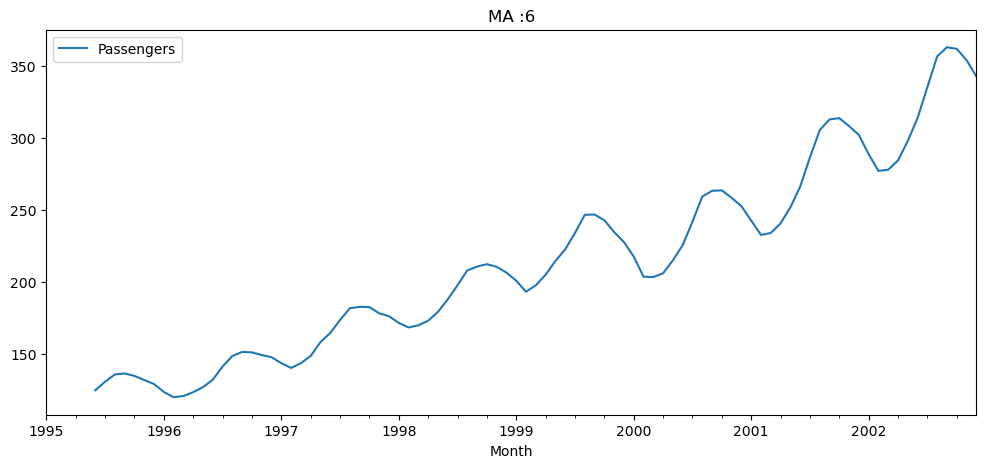

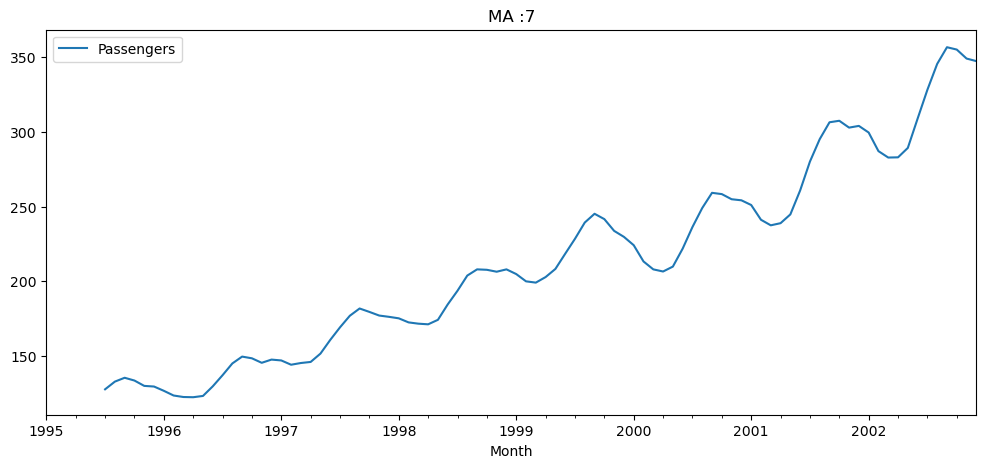

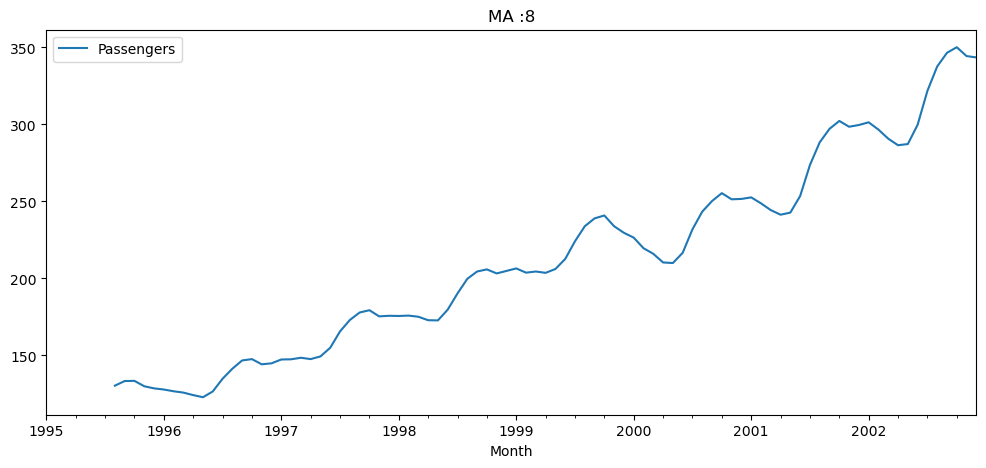

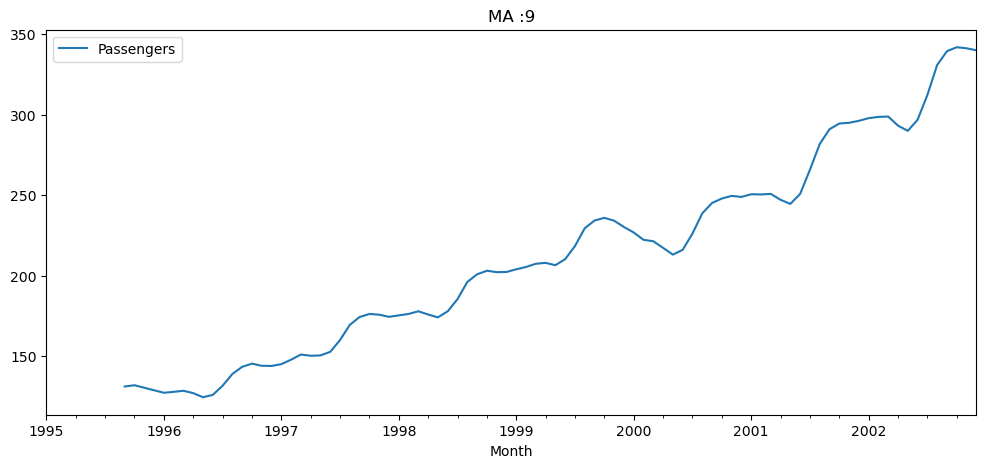

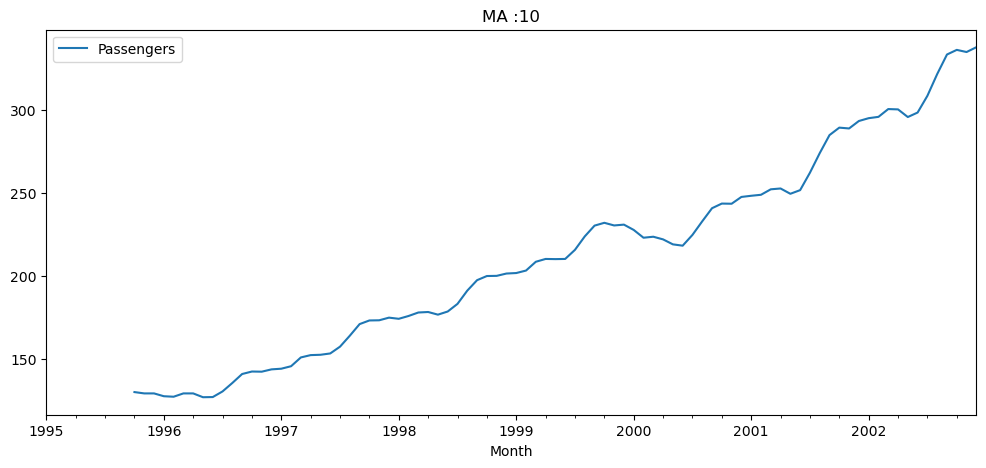

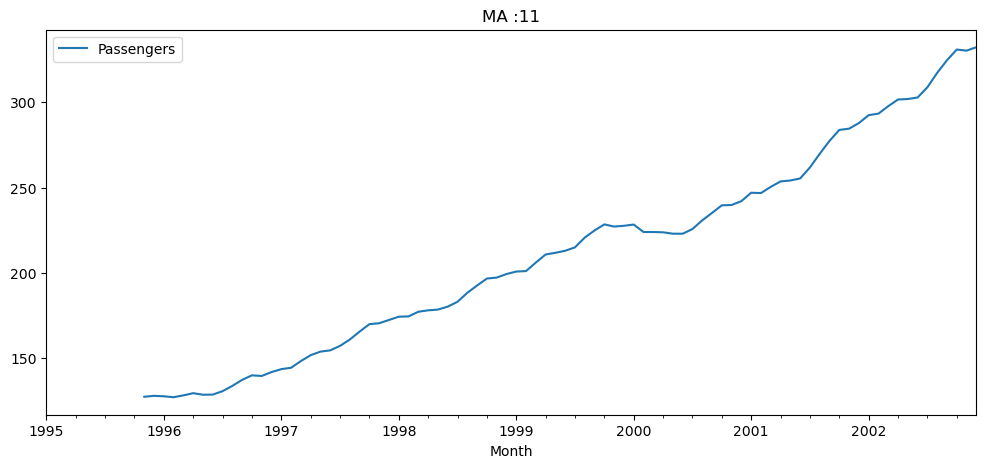

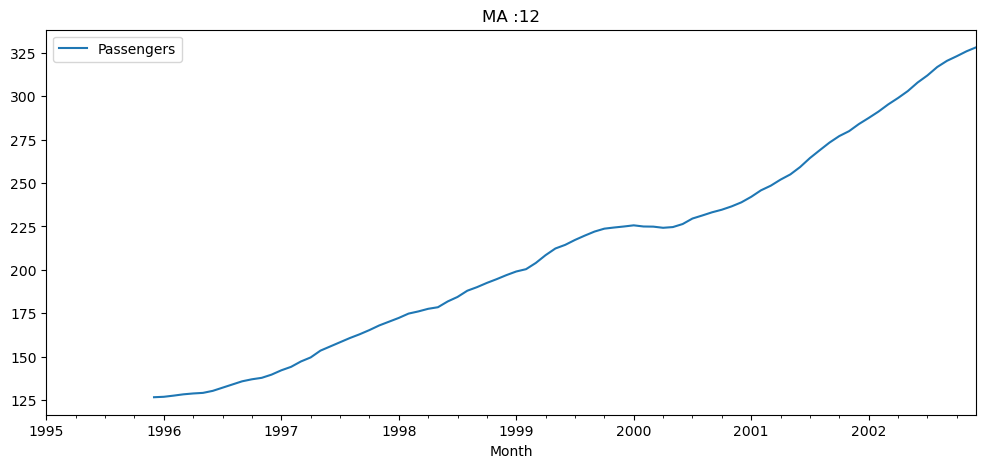

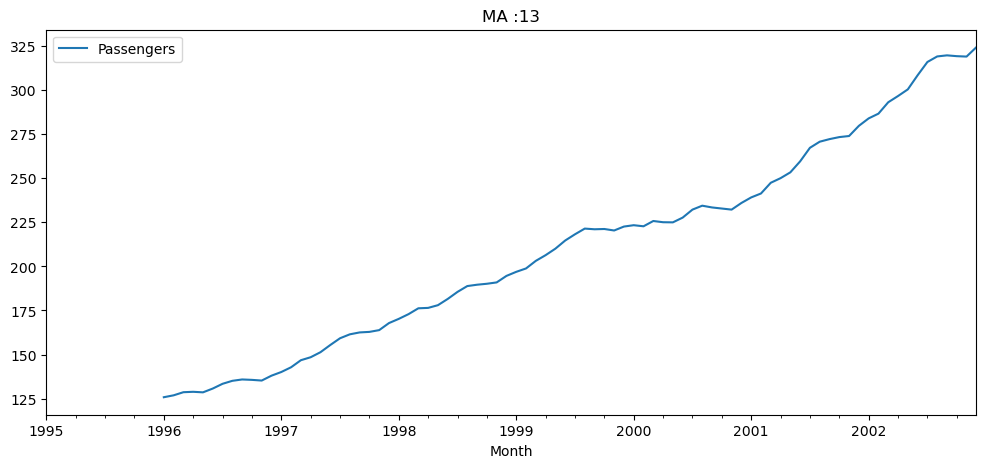

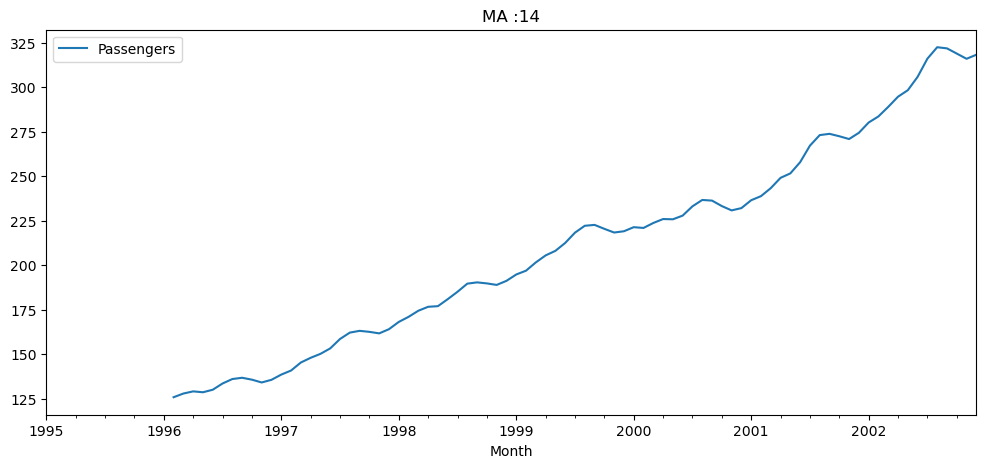

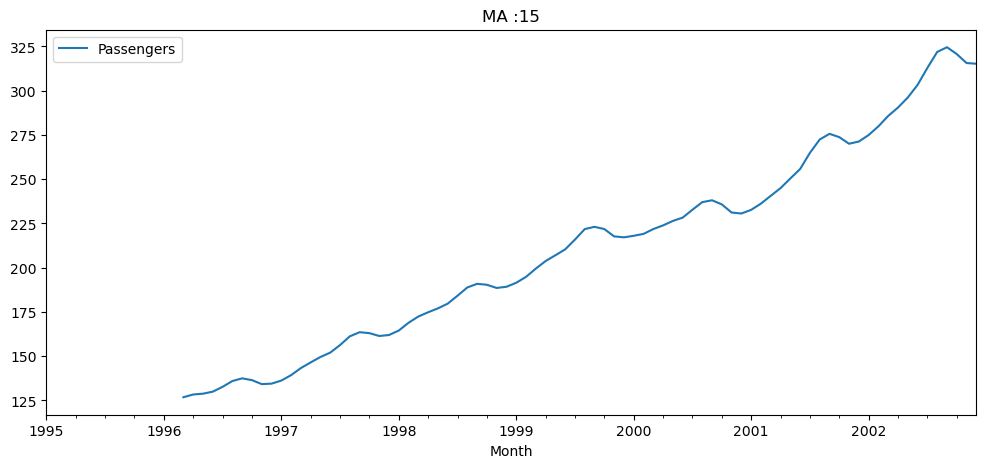

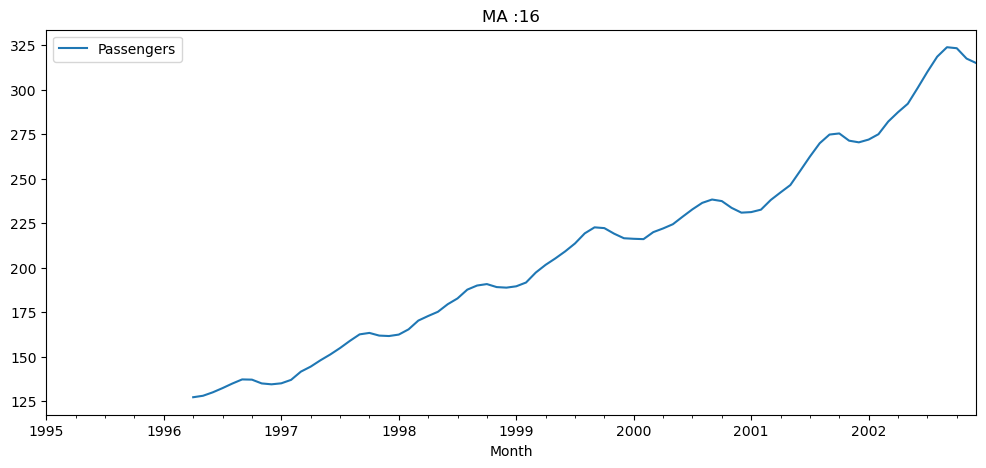

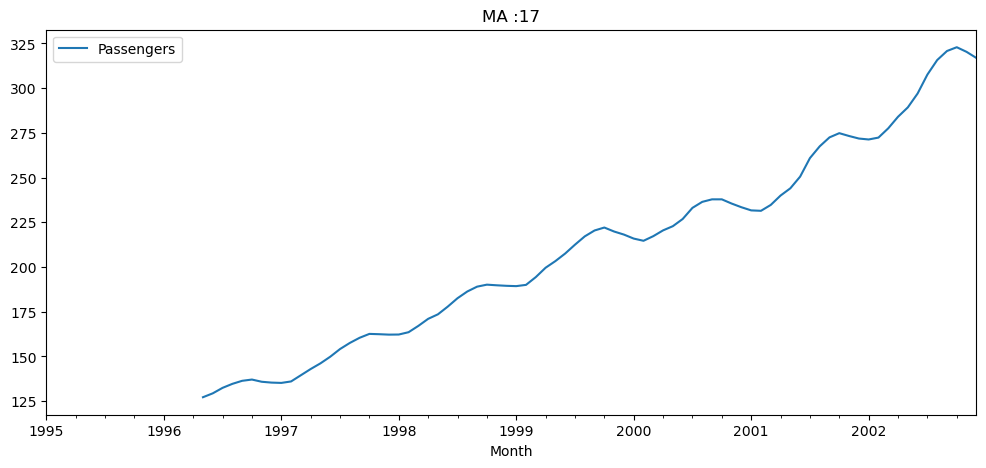

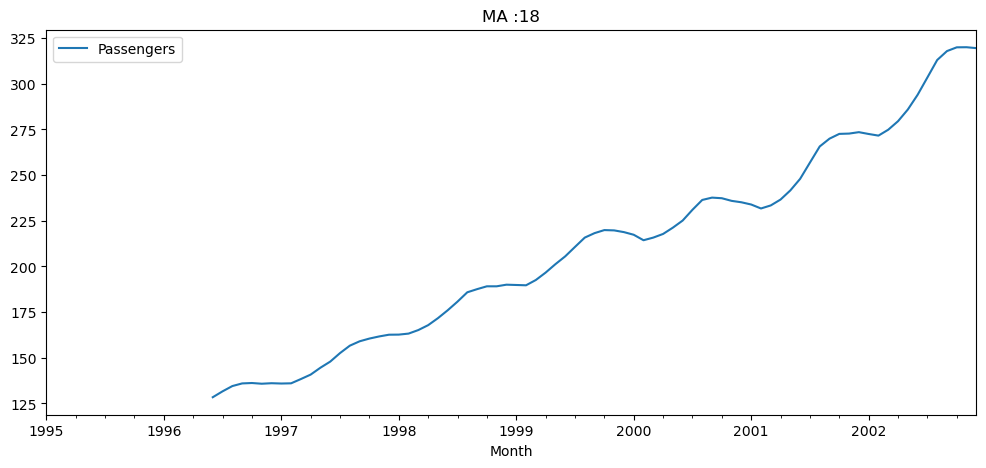

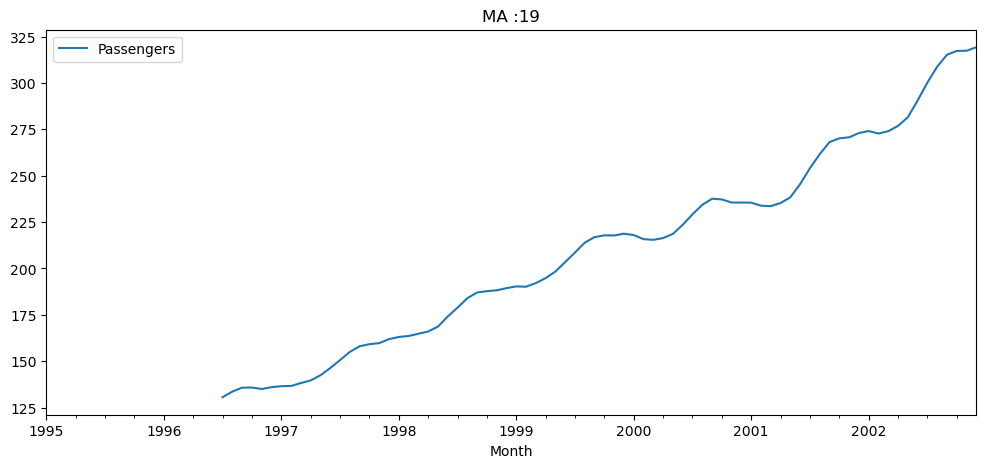

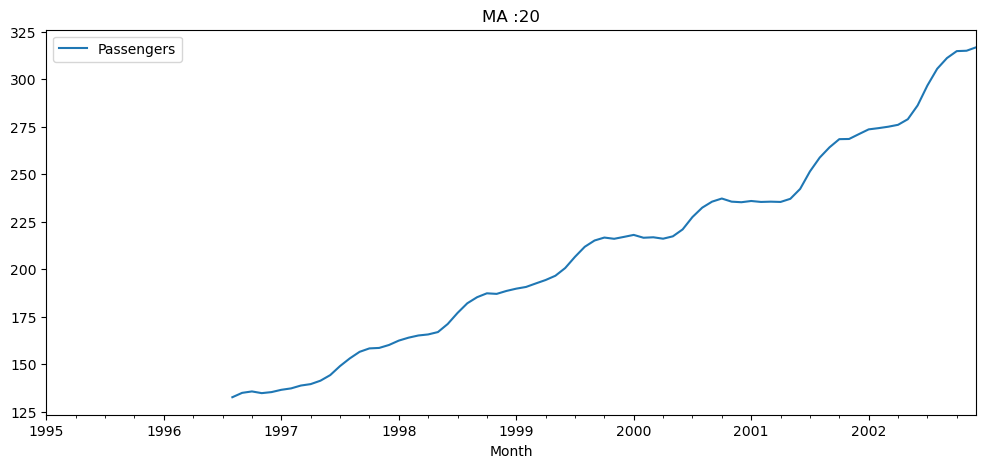

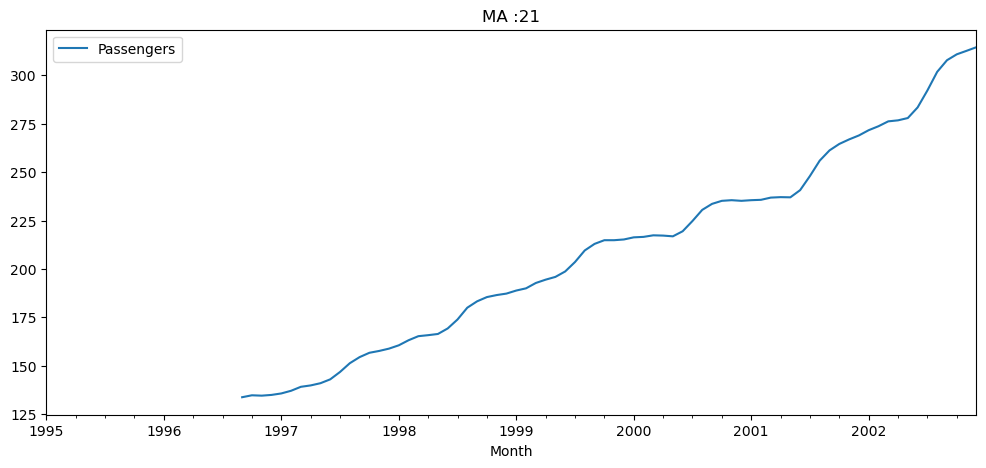

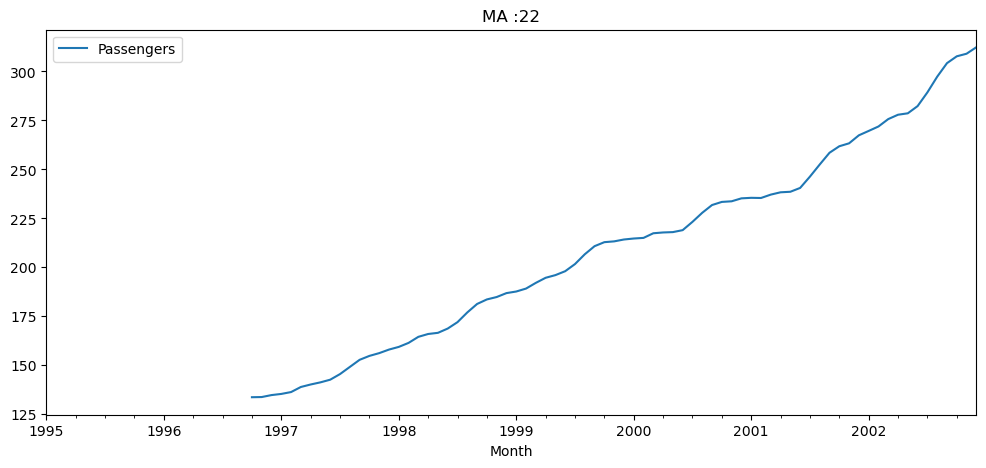

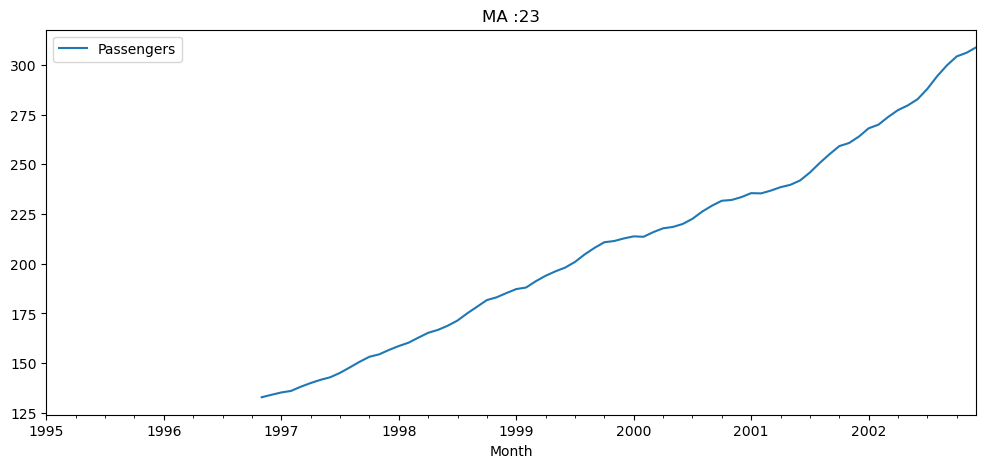

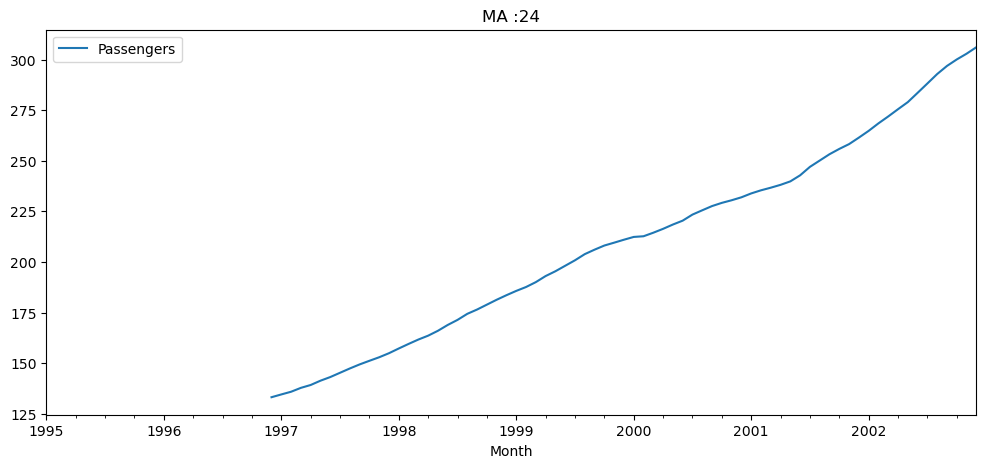

In [11]:
data_airlines.plot()
plt.title("original")
plt.legend(loc = 'best')
plt.show()

for i in range(2, 25):
    data_airlines.rolling(window = i).mean().plot(label = str(i))
    plt.title("MA :"+str(i))
    plt.legend(loc = 'best')
    plt.show()

# Time series decomposition 

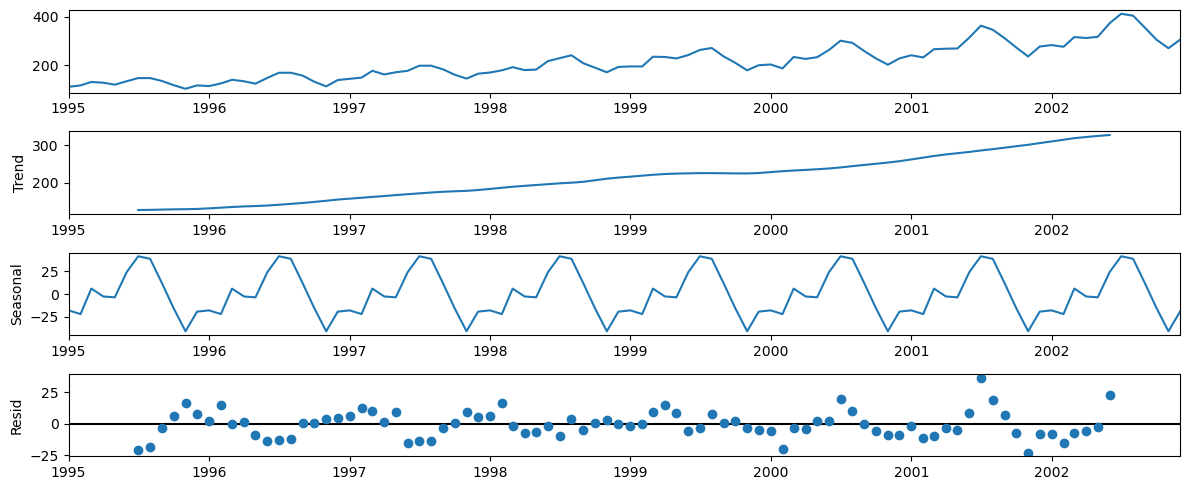

In [12]:
seasonal_decompose(data_airlines).plot();

# Evaluation metric RMSE

In [13]:
def RMSE(org,pred):
    rmse = sqrt(mean_squared_error(org, pred))
    return rmse

# 1. Simple Exponential Method

In [14]:
simple_model=SimpleExpSmoothing(train["Passengers"]).fit()
pred_sim=simple_model.predict(start=test.index[0],end=test.index[-1])
SEM=RMSE(test.Passengers,pred_sim)
print("RMSE values for Simple Exponential :",RMSE(test.Passengers,pred_sim))

RMSE values for Simple Exponential : 52.41850787734875


# 2.Holt method

In [15]:
holt_model=Holt(train["Passengers"]).fit()
pred_holt=holt_model.predict(start=test.index[0],end=test.index[-1])
HM=RMSE(test.Passengers,pred_holt)
print("RMSE values for holt :",RMSE(test.Passengers,pred_holt))

RMSE values for holt : 59.02198929002309


# 3 Holts winter exponential smoothing with additive seasonality and additive trend

In [16]:
holt_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal = "add",trend = "add",seasonal_periods = 4).fit()
pred_holt_add_add = holt_model_add_add.predict(start = test.index[0],end = test.index[-1])
HWEA=RMSE(test.Passengers, pred_holt_add_add)
print('RMSE Value of Holts add and add :',RMSE(test.Passengers, pred_holt_add_add))

RMSE Value of Holts add and add : 61.31141109718558


# 4 Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [17]:
holt_model_multi_add = ExponentialSmoothing(train["Passengers"],seasonal = "mul",trend = "add",seasonal_periods = 4).fit()
pred_holt_multi_add = holt_model_multi_add.predict(start = test.index[0],end = test.index[-1])
HWEM=RMSE(test.Passengers, pred_holt_multi_add)
print('RMSE Value of Holts multi and add :',RMSE(test.Passengers, pred_holt_multi_add))

RMSE Value of Holts multi and add : 64.16296718553953


# Model based forecasting methods

In [18]:
data_passenger=data_airlines.copy()
data_passenger.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [19]:
data_passenger["t"]=np.arange(1,97)
data_passenger["t_squared"]=data_passenger["t"]*data_passenger["t"]
data_passenger["log_passenger"]=np.log(data_passenger["Passengers"])
data_passenger.head()

,Passengers,t,t_squared,log_passenger
Month,,,,
1995-01-01,112,1,1,4.718499
1995-02-01,118,2,4,4.770685
1995-03-01,132,3,9,4.882802
1995-04-01,129,4,16,4.859812
1995-05-01,121,5,25,4.795791


# train test split

In [20]:
train=data_passenger.head(90)
test=data_passenger.tail(10)

# Linear model

In [21]:
linear_model = smf.ols('Passengers~t',data = train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))

LM=RMSE(test['Passengers'], pred_linear)
print('RMSE Value of Linear :',RMSE(test['Passengers'], pred_linear))

RMSE Value of Linear : 55.070010346721496


# Exponential Model

In [22]:
Exp_model = smf.ols('log_passenger~t',data = train).fit()
pred_Exp = pd.Series(Exp_model.predict(pd.DataFrame(test['t'])))

EM=RMSE(test['Passengers'], np.exp(pred_Exp))
print('RMSE Value of Exponential :',RMSE(test['Passengers'], np.exp(pred_Exp)))

RMSE Value of Exponential : 49.155468618093906


# Quadratic model

In [23]:
Quad_model= smf.ols('Passengers~t+t_squared',data = train).fit()
pred_Quad = pd.Series(Quad_model.predict(test[["t","t_squared"]]))

QM=RMSE(test['Passengers'], pred_Quad)
print('RMSE Value of Quadratic :',RMSE(test['Passengers'], pred_Quad))

RMSE Value of Quadratic : 49.782590877443624


# ARIMA model

In [24]:
series = data_airlines.copy()
series.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


# Creating a validation dataset 

In [25]:
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header = False)
validation.to_csv('validation.csv', header = False)

Dataset 84, Validation 12


# Creating a base model for evaluation

In [26]:
Arima_data=pd.read_excel("Airlines+Data.xlsx")
Arima_data=Arima_data["Passengers"]
Arima_data.head()

0    112
1    118
2    132
3    129
4    121
Name: Passengers, dtype: int64

In [27]:
X = Arima_data.values
X = X.astype('float32')
train_size = int(len(X) * 0.715)
train, test = X[0:train_size], X[train_size:]

In [28]:
print(train.shape)
print(test.shape)

(68,)
(28,)


# Walk Farward Validation

In [29]:
history = [x for x in train]
predictions = list()

In [30]:
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)

    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>Predicted=229.000, Expected=203.000
>Predicted=203.000, Expected=229.000
>Predicted=229.000, Expected=242.000
>Predicted=242.000, Expected=233.000
>Predicted=233.000, Expected=267.000
>Predicted=267.000, Expected=269.000
>Predicted=269.000, Expected=270.000
>Predicted=270.000, Expected=315.000
>Predicted=315.000, Expected=364.000
>Predicted=364.000, Expected=347.000
>Predicted=347.000, Expected=312.000
>Predicted=312.000, Expected=274.000
>Predicted=274.000, Expected=237.000
>Predicted=237.000, Expected=278.000
>Predicted=278.000, Expected=284.000
>Predicted=284.000, Expected=277.000
>Predicted=277.000, Expected=317.000
>Predicted=317.000, Expected=313.000
>Predicted=313.000, Expected=318.000
>Predicted=318.000, Expected=374.000
>Predicted=374.000, Expected=413.000
>Predicted=413.000, Expected=405.000
>Predicted=405.000, Expected=355.000
>Predicted=355.000, Expected=306.000
>Predicted=306.000, Expected=271.000
>

In [31]:
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE Value : %.3f' % rmse)

RMSE Value : 32.211


In [32]:
rmse_Persistence_model = 32.211

# Evaluation

In [33]:
list = [['Simple Exponential Method',SEM], ['Holt method',HM],
          ['Holt exp smoothing add',HWEA],['Holt exp smoothing multi',HWEM],
          ['Linear Model',LM],['Exponential model',EM],['Quadratic model',QM],
          ['Persistence/ Base model', rmse_Persistence_model]]

In [34]:
df = pd.DataFrame(list, columns = ['Model', 'RMSE_Value']) 
df

,Model,RMSE_Value
0,Simple Exponential Method,52.418508
1,Holt method,59.021989
2,Holt exp smoothing add,61.311411
3,Holt exp smoothing multi,64.162967
4,Linear Model,55.070010
5,Exponential model,49.155469
6,Quadratic model,49.782591
7,Persistence/ Base model,32.211000


#### Holts winter exponential smoothing with multiplicative seasonality and additive trend has the highest value of RMSE and hence is chosen for deployment.

In [35]:
train=data_airlines[:84]
test=data_airlines[84:]

In [36]:
holt_model_multi_add = ExponentialSmoothing(train['Passengers'], trend = 'add', seasonal = 'mul', seasonal_periods = 12).fit()

In [37]:
Forecast = holt_model_multi_add.forecast(25)

In [38]:
Forecast

2002-01-01    281.194412
2002-02-01    278.386649
2002-03-01    322.560801
2002-04-01    312.458639
2002-05-01    311.026816
2002-06-01    348.878462
2002-07-01    389.549464
2002-08-01    384.754930
2002-09-01    341.861188
2002-10-01    300.740169
2002-11-01    262.171701
2002-12-01    299.378258
2003-01-01    304.813899
2003-02-01    301.607750
2003-03-01    349.280873
2003-04-01    338.164425
2003-05-01    336.440575
2003-06-01    377.192258
2003-07-01    420.951607
2003-08-01    415.563618
2003-09-01    369.053771
2003-10-01    324.504351
2003-11-01    282.752717
2003-12-01    322.727320
2004-01-01    328.433385
Freq: MS, dtype: float64

<AxesSubplot:>

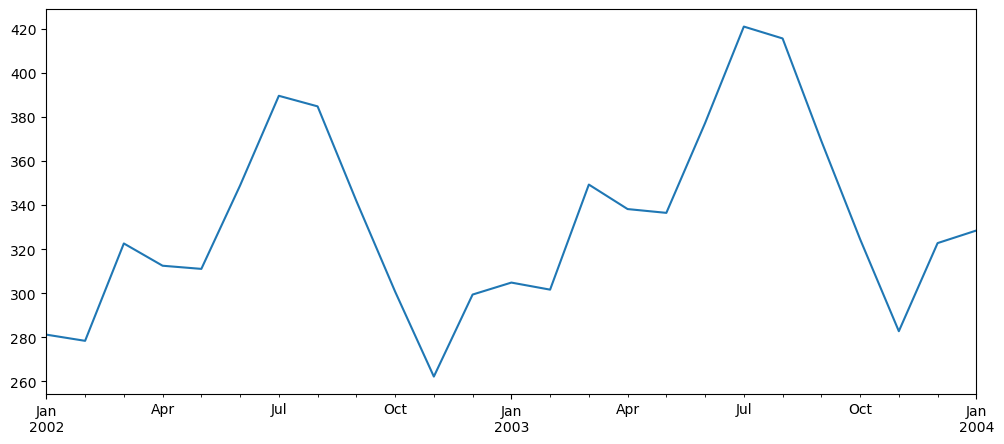

In [39]:
Forecast.plot()

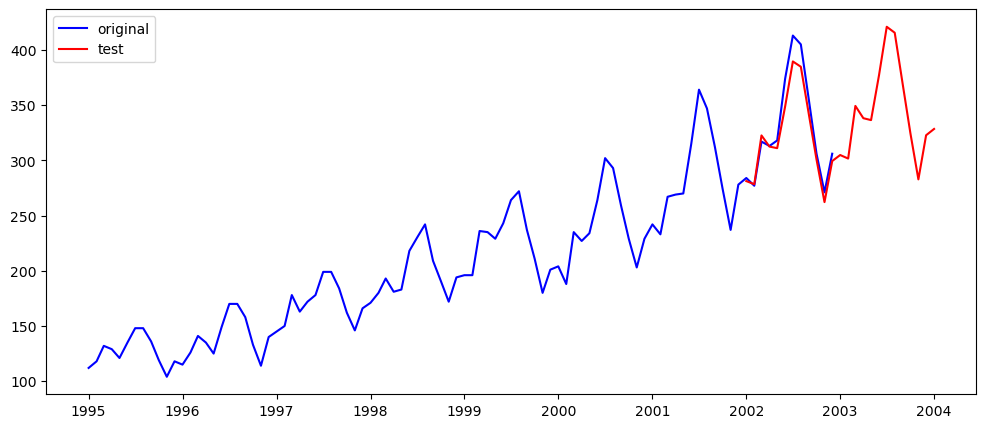

In [40]:
plt.plot(data_airlines, color = 'blue', label = 'original')
plt.plot(Forecast, color = 'red', label = 'test')
plt.legend(loc = 'best')
plt.show()